In [584]:
import csv
import json
import numpy as np
import pickle
import re
import sys
import matplotlib.pyplot as plt
from collections import defaultdict

In [585]:
def is_kernel():
    if 'IPython' not in sys.modules:
        return False
    from IPython import get_ipython
    return getattr(get_ipython(), 'kernel', None) is not None

In [586]:
if not is_kernel():
    if len(sys.argv) <= 1:
        print("Need to specify input size.")
        sys.exit()
    INPUT_SIZE = sys.argv[1]
else:
    INPUT_SIZE = "Small"

#### Parse out the county-level flu rates.

In [587]:
OUTPUT_FILE = "out/output_%s.txt" % INPUT_SIZE.lower()

In [588]:
pos_pattern = r"query : county_rate\(County\[(\d+)\], Week\[(\d+)\]\)\n{2}Mean = (\d+\.\d+)\s"
neg_pattern = r"query : county_rate\(County\[(\d+)\], Week\[(\d+)\]\)\n{2}Mean = -(\d+\.\d+)\s"

with open(OUTPUT_FILE, "r") as output_file:
    pos_searches = re.findall(pos_pattern, output_file.read())
    output_file.seek(0)
    neg_searches = re.findall(neg_pattern, output_file.read())
    
searches = pos_searches + neg_searches

In [589]:
predictions = {}
for q in searches:
    predictions[int(q[0]), int(q[1])] = float(q[2])

In [590]:
for k, v in predictions.items():
    if v < 0:
        predictions[k] = 0
    if v > 0.5:
        predictions[k] = 0

In [591]:
with open("log/index_to_county.pickle", "rb") as picklefile:
    index_to_county = pickle.load(picklefile)

In [592]:
with open("log/dates.pickle", "rb") as picklefile:
    dates = pickle.load(picklefile)

In [593]:
with open("log/index_to_region.pickle", "rb") as picklefile:
    index_to_region = pickle.load(picklefile)

#### Write output JSON.

In [594]:
output_dict = {}

In [595]:
for (i, fips) in index_to_county.items():
    county_dict = {
        "ILI percentage %": {}
    }
    for j, t in enumerate(dates):
        county_dict["ILI percentage %"][t] = predictions[(i,j)] * 100.0
    output_dict[fips] = county_dict

In [596]:
with open("out/%s/CountyWeeklyILI.json" % INPUT_SIZE, "w") as jsonfile:
    jsonfile.write(json.dumps(output_dict))

#### Evaluate

In [597]:
eval_data = []

In [598]:
with open("data/%s/eval/Flu_ILI_TRUTH.csv" % INPUT_SIZE, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        eval_data.append(row)

In [599]:
county_map_matrix = np.loadtxt("./data_processed/county_map.txt")
region_pop_matrix = np.loadtxt("./data_processed/region_pops.txt")

In [600]:
print(county_map_matrix.shape)
print(region_pop_matrix.shape)

(9, 82)
(9,)


**Graphs**

In [618]:
history = []
county_level_history = []

In [619]:
loss = 0.0

In [620]:
for t, date in enumerate(dates):
    county_vector = [predictions[(i, t)] for i in index_to_county.keys()]
    region_rates = np.dot(county_map_matrix, county_vector) / np.sum(county_map_matrix, axis = 1)
    history.append(region_rates)
    county_level_history.append(county_vector)
    for i, predicted_rate in enumerate(region_rates):
        if eval_data[t][index_to_region[i]] != 'NaN':
            loss += region_pop_matrix[i] * (predicted_rate * 100 - float(eval_data[t][index_to_region[i]][0:-1]))**2

In [621]:
print("Total loss:", loss)

Total loss: 4717500336.69


In [622]:
print("MSE:", loss / np.sum(region_pop_matrix) / np.sum(len(dates)))

MSE: 15.2971829209


In [623]:
print("RMSE:", (loss / np.sum(region_pop_matrix) / np.sum(len(dates)))**0.5)

RMSE: 3.91116132637


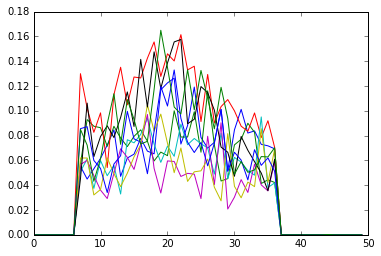

In [624]:
plt.figure()
plt.plot(np.array(history)[:50,:])
plt.savefig("out/%s/output.png" % INPUT_SIZE)

In [625]:
obs = np.loadtxt('../cp7/data_processed/obs.txt')

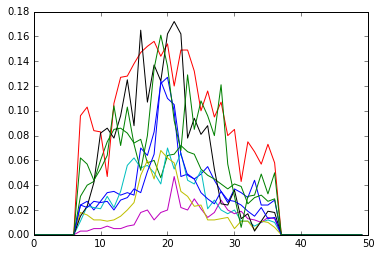

In [626]:
plt.figure()
plt.plot(obs[:50,:])
plt.savefig("out/%s/ref.png" % INPUT_SIZE)

In [628]:
county_level_history= np.array(county_level_history)

(103, 82)